### Notebook for the QC analysis of anndata object with Fawkner-Corbett_2021 Visium data 

- **Developed by:** Anna Maguza
- **Place:** Wuerzburg Institute for System Immunology
- **Date:** 27th January 2024

#### Import packages

In [1]:
import pandas as pd
import anndata
import os
import scanpy as sc
import numpy as np

from scipy.sparse import issparse


#### Set up cells

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 160, color_map = 'RdPu', dpi_save = 180, vector_friendly = True, format = 'svg')

-----
anndata     0.10.5.post1
scanpy      1.9.8
-----
PIL                         10.2.0
anyio                       NA
arrow                       1.3.0
asciitree                   NA
asttokens                   NA
attr                        23.2.0
attrs                       23.2.0
babel                       2.14.0
backcall                    0.2.0
beta_ufunc                  NA
binom_ufunc                 NA
brotli                      1.1.0
certifi                     2023.11.17
cffi                        1.16.0
charset_normalizer          3.3.2
cloudpickle                 3.0.0
comm                        0.2.1
cycler                      0.12.1
cython_runtime              NA
dask                        2024.1.1
dask_image                  2023.08.1
datashader                  0.16.0
datatree                    0.0.13
dateutil                    2.8.2
debugpy                     1.8.0
decorator                   5.1.1
defusedxml                  0.7.1
docrep                   

#### Load anndata object

In [3]:
input = '/mnt/LaCIE/annaM/gut_project/raw_data/Fawkner-Corbett_2021/Fawkner_Corbett_2021_raw_all_samples_unprocesses.h5ad'
adata = anndata.read_h5ad(input)

/home/amaguza/miniforge3/envs/squidpy_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1906: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/amaguza/miniforge3/envs/squidpy_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [4]:
# check if there are not unique indexes in adata.obs
adata.obs.index.is_unique

False

In [5]:
adata.obs['barcode'] = adata.obs.index.copy()

adata.obs['barcode_sample_ID'] = adata.obs['barcode'].astype(str) + '_' + adata.obs['Sample_ID'].astype(str)

adata.obs.index = adata.obs['barcode_sample_ID']

In [6]:
# check if there are not unique indexes in adata.obs
adata.obs.index.is_unique

False

In [7]:
adata.obs['barcode_sample_ID'].value_counts()

barcode_sample_ID
TTTTTTTTTTTTTTTT_A9    2
CCACAATGTACGTCTT_A9    2
CCACGGTGCCCGGTAG_A9    2
CCACGAGAAGAGAATC_A9    2
CCACGAATTTAACCTC_A9    2
                      ..
ACCCTATGCCATATCG_A3    1
ACCCTATAGGACTGAG_A3    1
ACCCGTGTCATCAGTA_A3    1
ACCCGTAGTCTAGTTG_A3    1
CCAACGCTTGCCAGGG_A4    1
Name: count, Length: 19560, dtype: int64

In [8]:
def check_duplicate_cells(adata, num_genes=100):
    # Ensure num_genes is not greater than the total number of genes
    num_genes = min(num_genes, adata.shape[1])

    # Get a random selection of gene indices
    rng = np.random.default_rng()  # Random number generator
    random_gene_indices = rng.choice(adata.shape[1], size=num_genes, replace=False)

    # Convert the sparse matrix to a DataFrame for easier handling if necessary
    # and only select the random genes
    expr_df = pd.DataFrame(adata.X[:, random_gene_indices].toarray() if issparse(adata.X) else adata.X[:, random_gene_indices], 
                           index=adata.obs.index, 
                           columns=adata.var_names[random_gene_indices])
    
    # Add the barcode as a column in the DataFrame
    expr_df['barcode'] = adata.obs.index

    # Function to check if all rows in the group are identical for the random genes
    def all_rows_identical(group):
        # If all rows are identical, the number of unique rows will be 1
        return group.drop(columns='barcode').drop_duplicates().shape[0] == 1

    # Group by barcode and apply the checking function
    inconsistent_barcodes = expr_df.groupby('barcode').filter(lambda x: not all_rows_identical(x))

    # Return the barcodes that have inconsistent gene expression data
    return inconsistent_barcodes['barcode'].unique()

# Use the function on your AnnData object
inconsistent_barcodes = check_duplicate_cells(adata)

# Print or process the barcodes that have inconsistencies
print("Barcodes with inconsistent gene expressions:", inconsistent_barcodes)

Barcodes with inconsistent gene expressions: []


In [9]:
def remove_duplicate_cells(adata):
    adata_unique = adata[~adata.obs.index.duplicated(keep='first')].copy()

    return adata_unique

# Use the function on your AnnData object
adata = remove_duplicate_cells(adata)


/home/amaguza/miniforge3/envs/squidpy_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1908: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [10]:
# check if there are not unique indexes in adata.obs
adata.obs.index.is_unique

True

In [11]:
adata.var_names_make_unique()

/home/amaguza/miniforge3/envs/squidpy_env/lib/python3.9/site-packages/anndata/utils.py:260: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`Example key collisions generated by the make_index_unique algorithm: ['SNORD115-1', 'SNORD115-2', 'SNORD115-3', 'SNORD115-4', 'SNORD115-5']
  warnings.warn(


* Basic filtering

In [12]:
sc.pp.filter_cells(adata, min_genes = 200)

filtered out 9 cells that have less than 200 genes expressed


#### Identify doublets

In [13]:
import scrublet

+ Sample A1

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.67
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 4.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.4%
Elapsed time: 1.7 seconds


/tmp/ipykernel_1477083/2395665730.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  a1.obs['doublet_scores'], a1.obs['predicted_doublets'] = scrub.scrub_doublets()


2

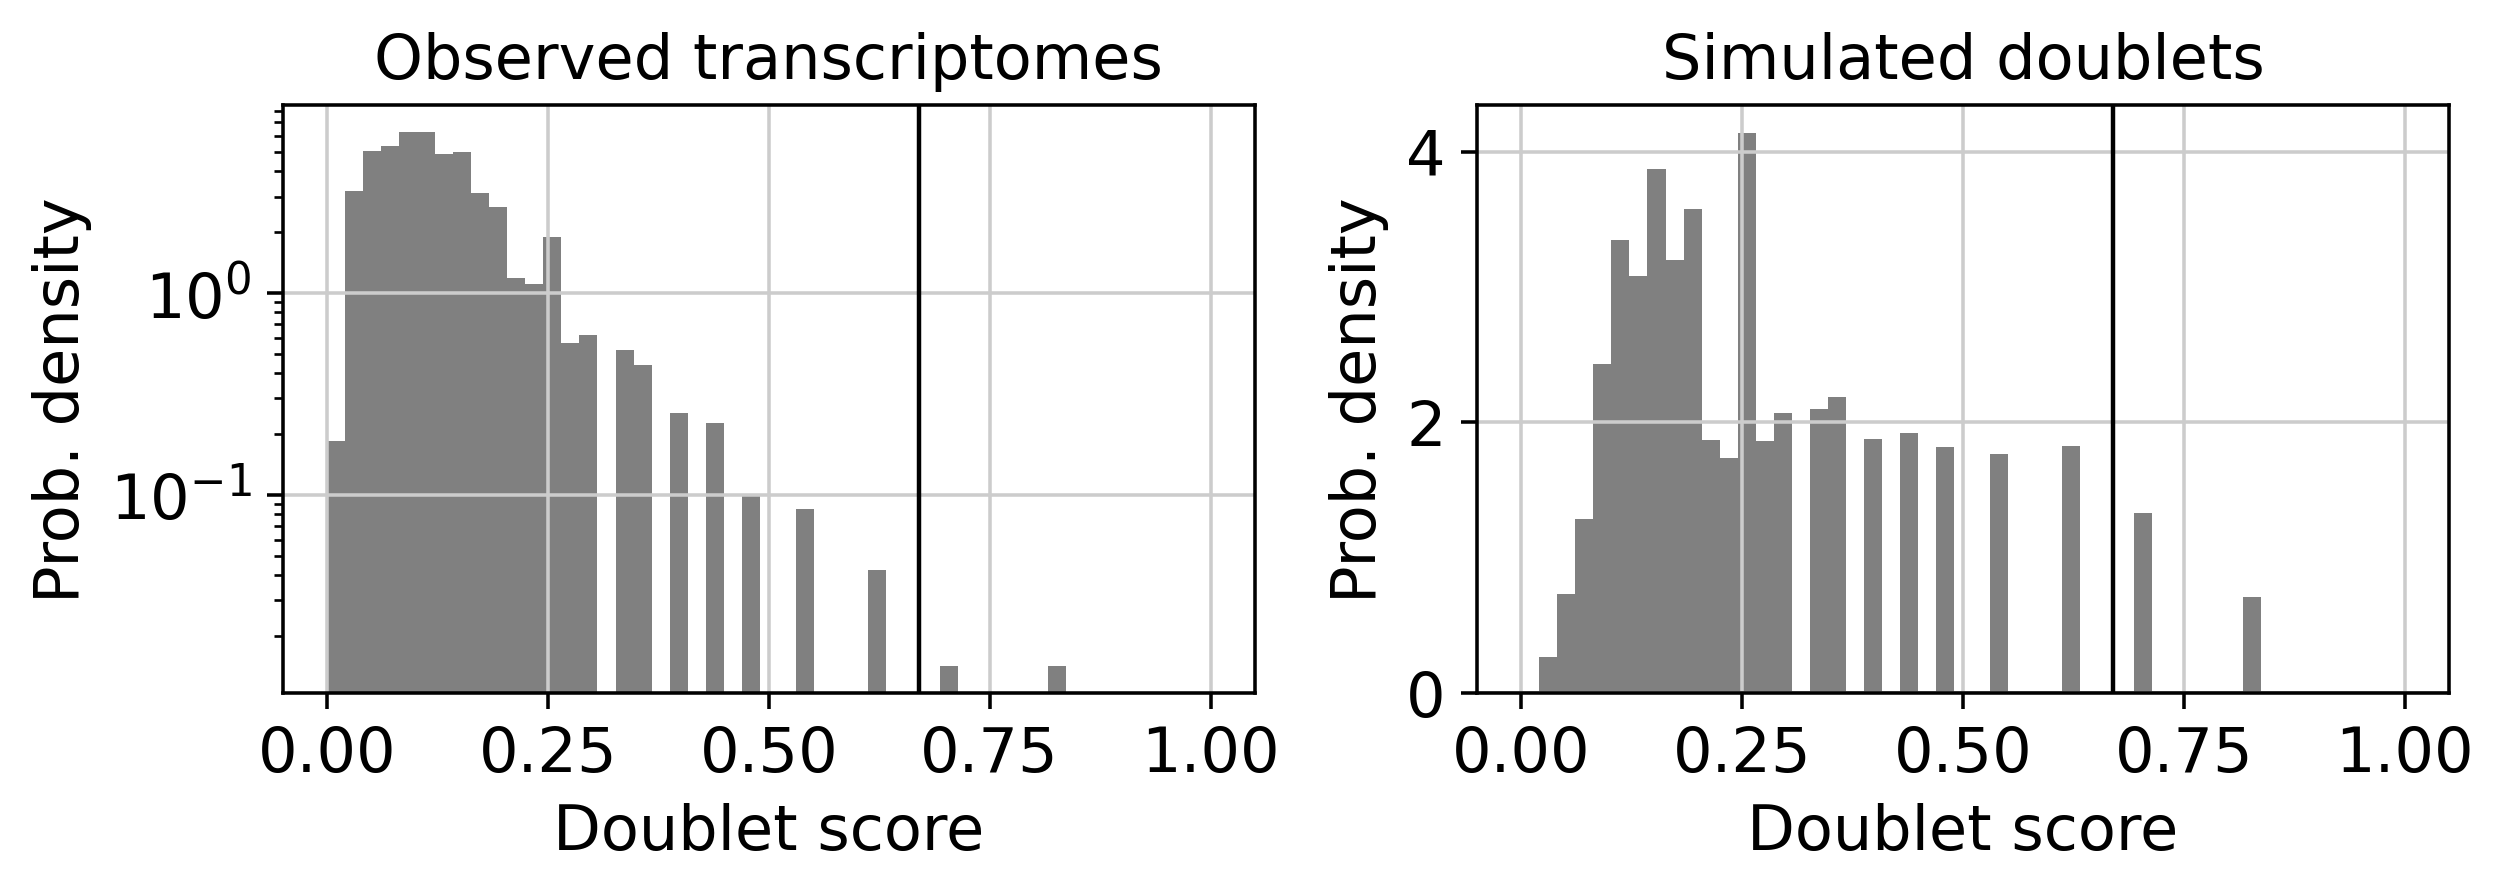

In [14]:
a1 = adata[adata.obs['Sample_ID'] == 'A1',:]
scrub = scrublet.Scrublet(a1.X)
a1.obs['doublet_scores'], a1.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(a1.obs['predicted_doublets'])

+ Sample A2

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.65
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 4.8%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 3.0%
Elapsed time: 1.8 seconds


/tmp/ipykernel_1477083/1558616946.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  a2.obs['doublet_scores'], a2.obs['predicted_doublets'] = scrub.scrub_doublets()


4

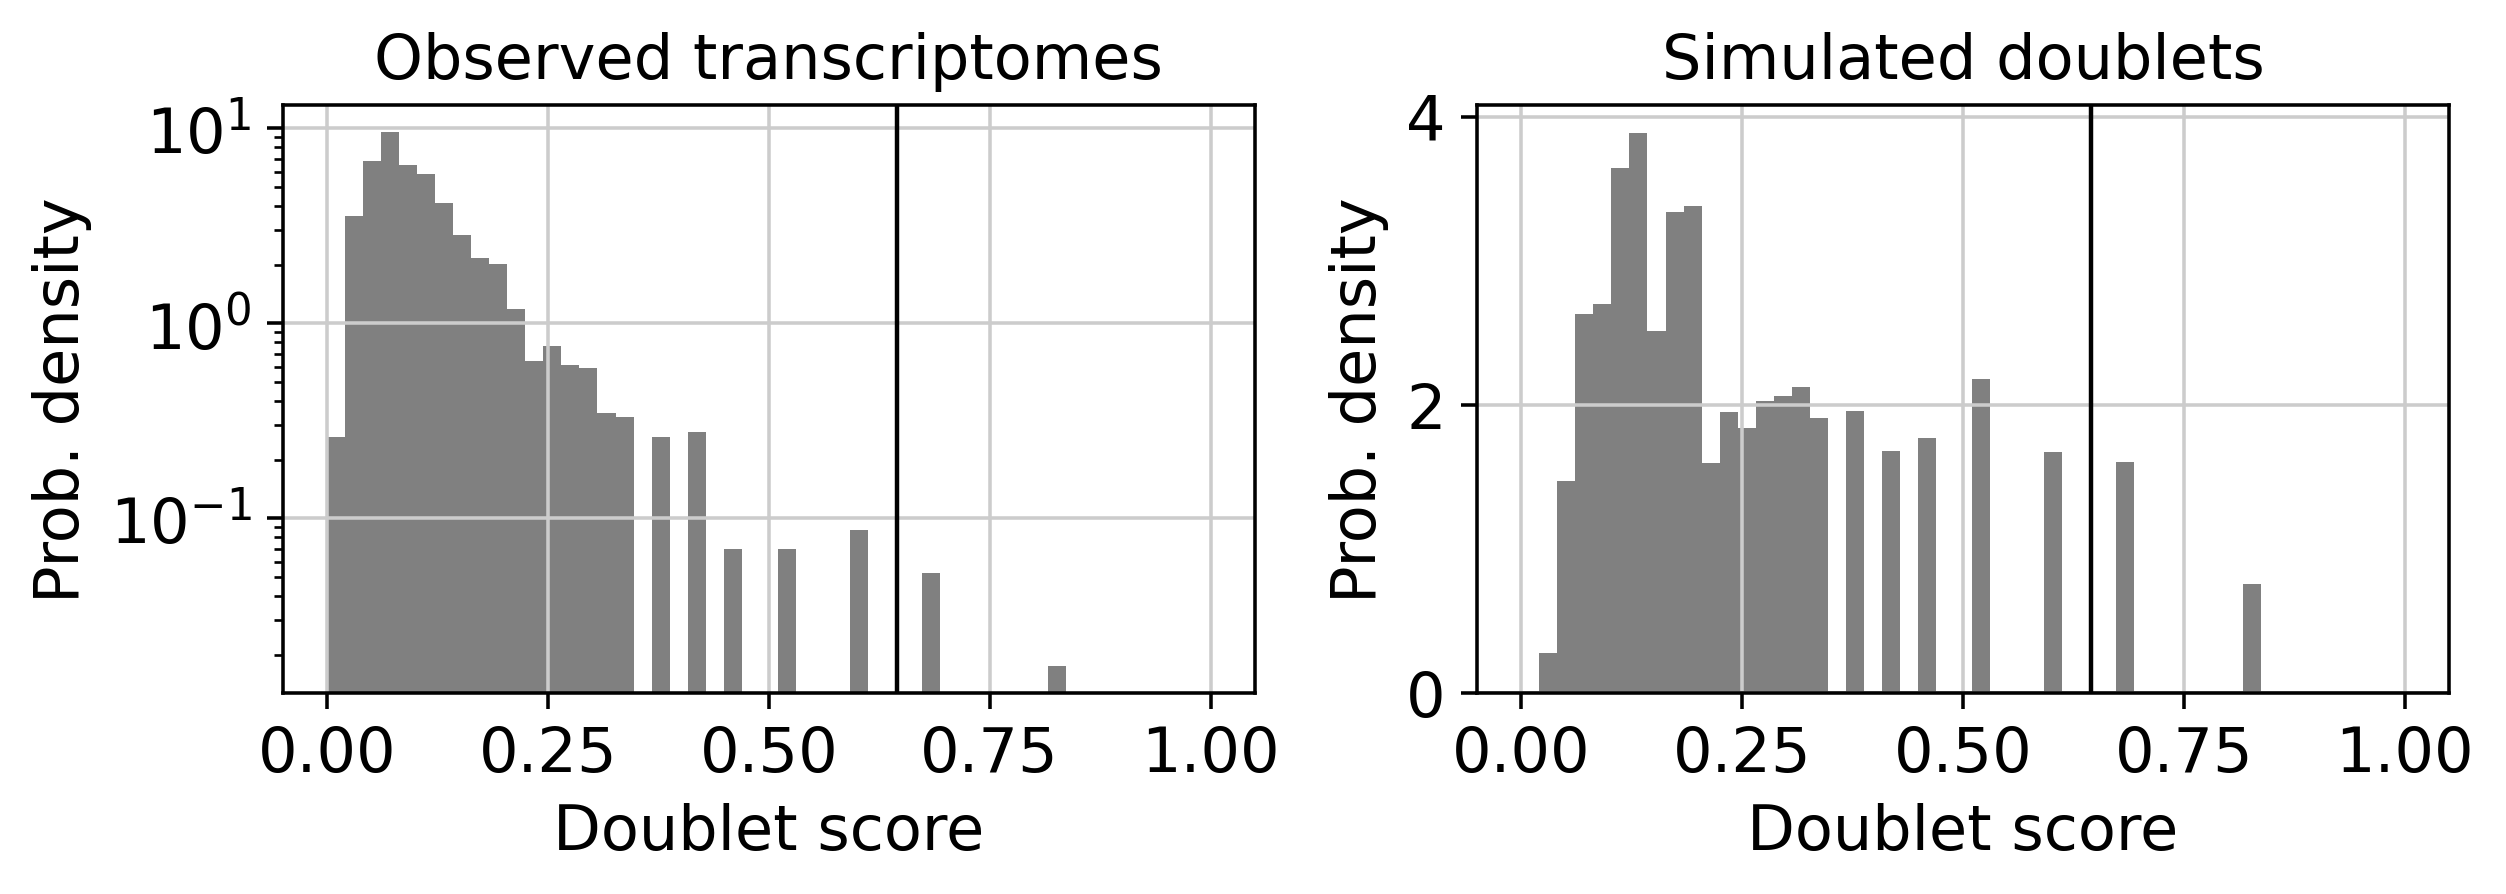

In [15]:
a2 = adata[adata.obs['Sample_ID'] == 'A2',:]
scrub = scrublet.Scrublet(a2.X)
a2.obs['doublet_scores'], a2.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(a2.obs['predicted_doublets'])

+ Sample A3

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.63
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 4.6%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.6%
Elapsed time: 1.6 seconds


/tmp/ipykernel_1477083/1291442088.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  a3.obs['doublet_scores'], a3.obs['predicted_doublets'] = scrub.scrub_doublets()


2

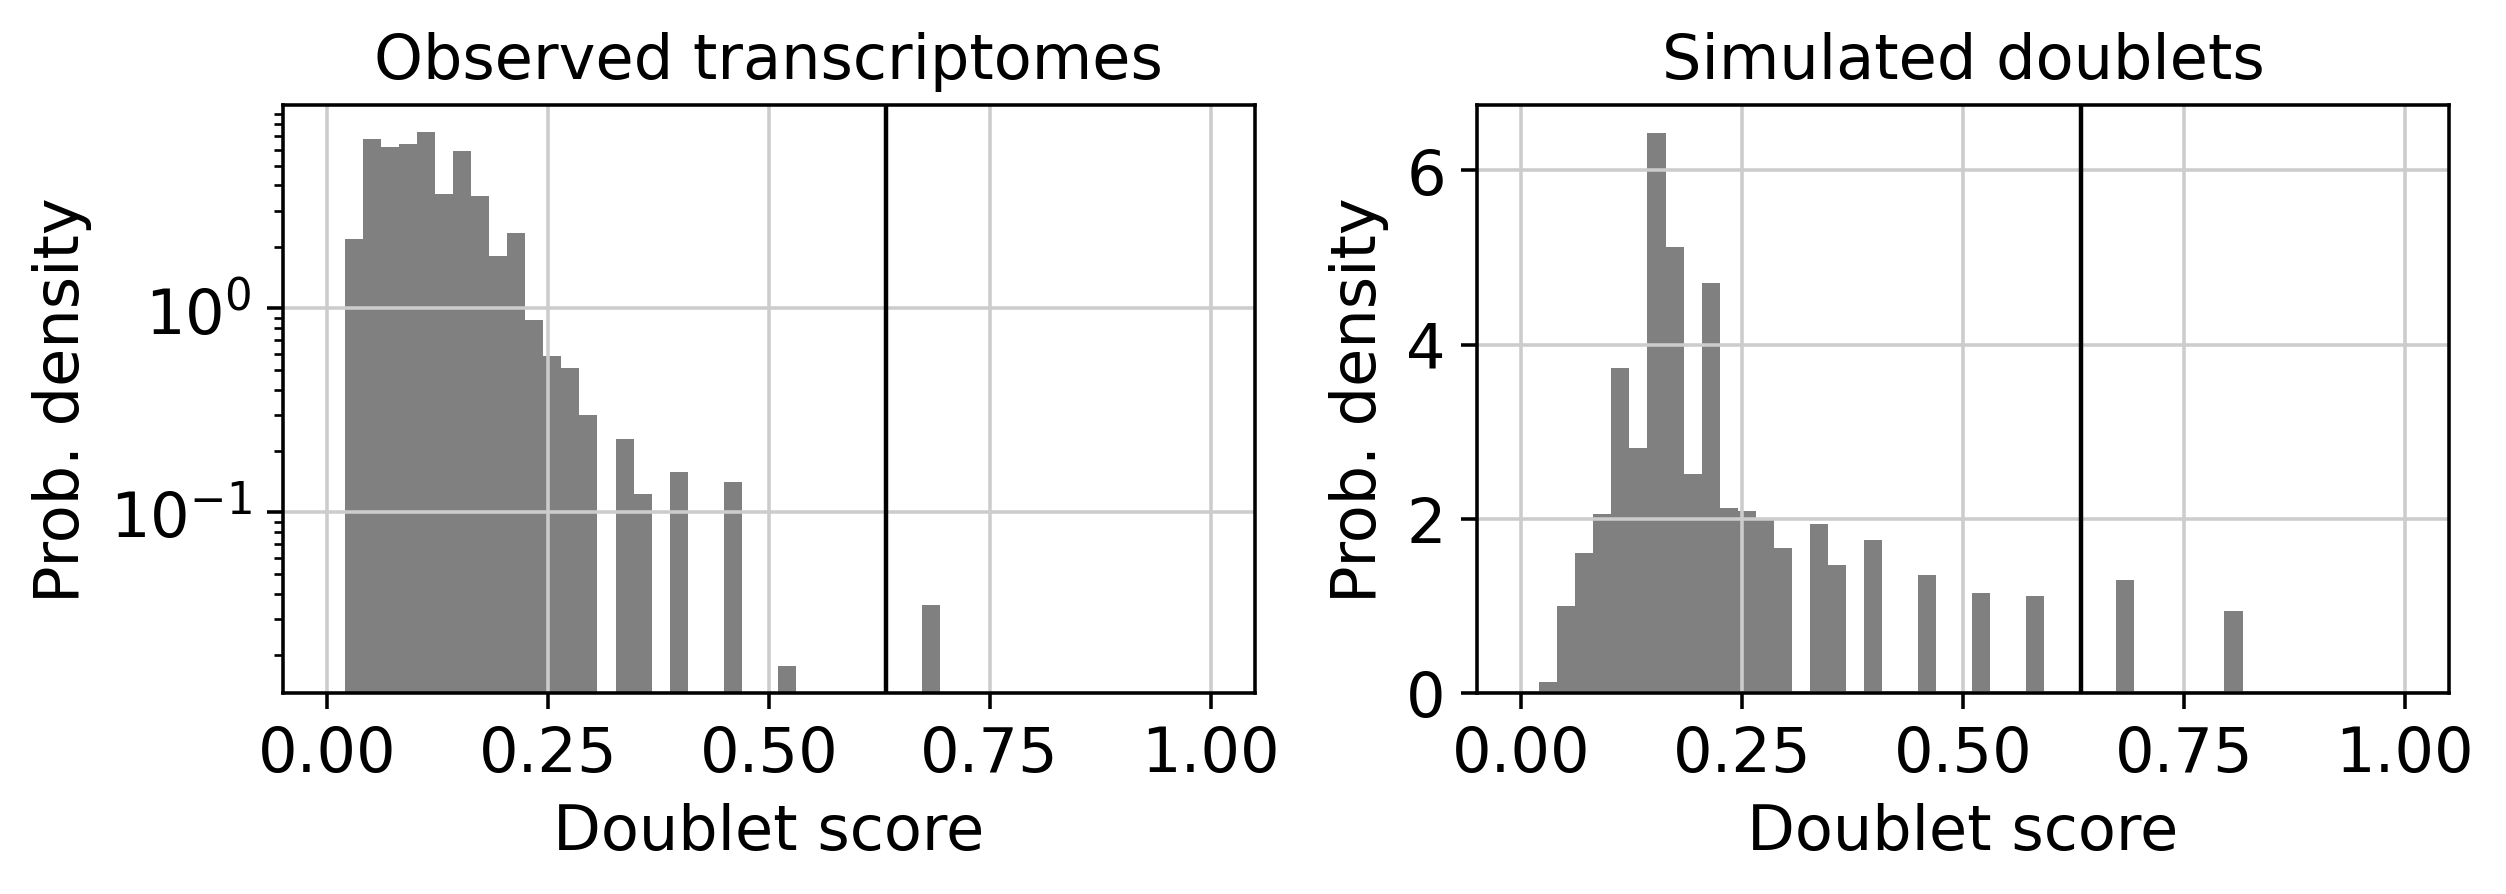

In [16]:
a3 = adata[adata.obs['Sample_ID'] == 'A3',:]
scrub = scrublet.Scrublet(a3.X)
a3.obs['doublet_scores'], a3.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(a3.obs['predicted_doublets'])

+ Sample A4

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.61
Detected doublet rate = 0.0%
Estimated detectable doublet fraction = 7.9%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 0.0%
Elapsed time: 1.6 seconds


/tmp/ipykernel_1477083/613485703.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  a4.obs['doublet_scores'], a4.obs['predicted_doublets'] = scrub.scrub_doublets()


0

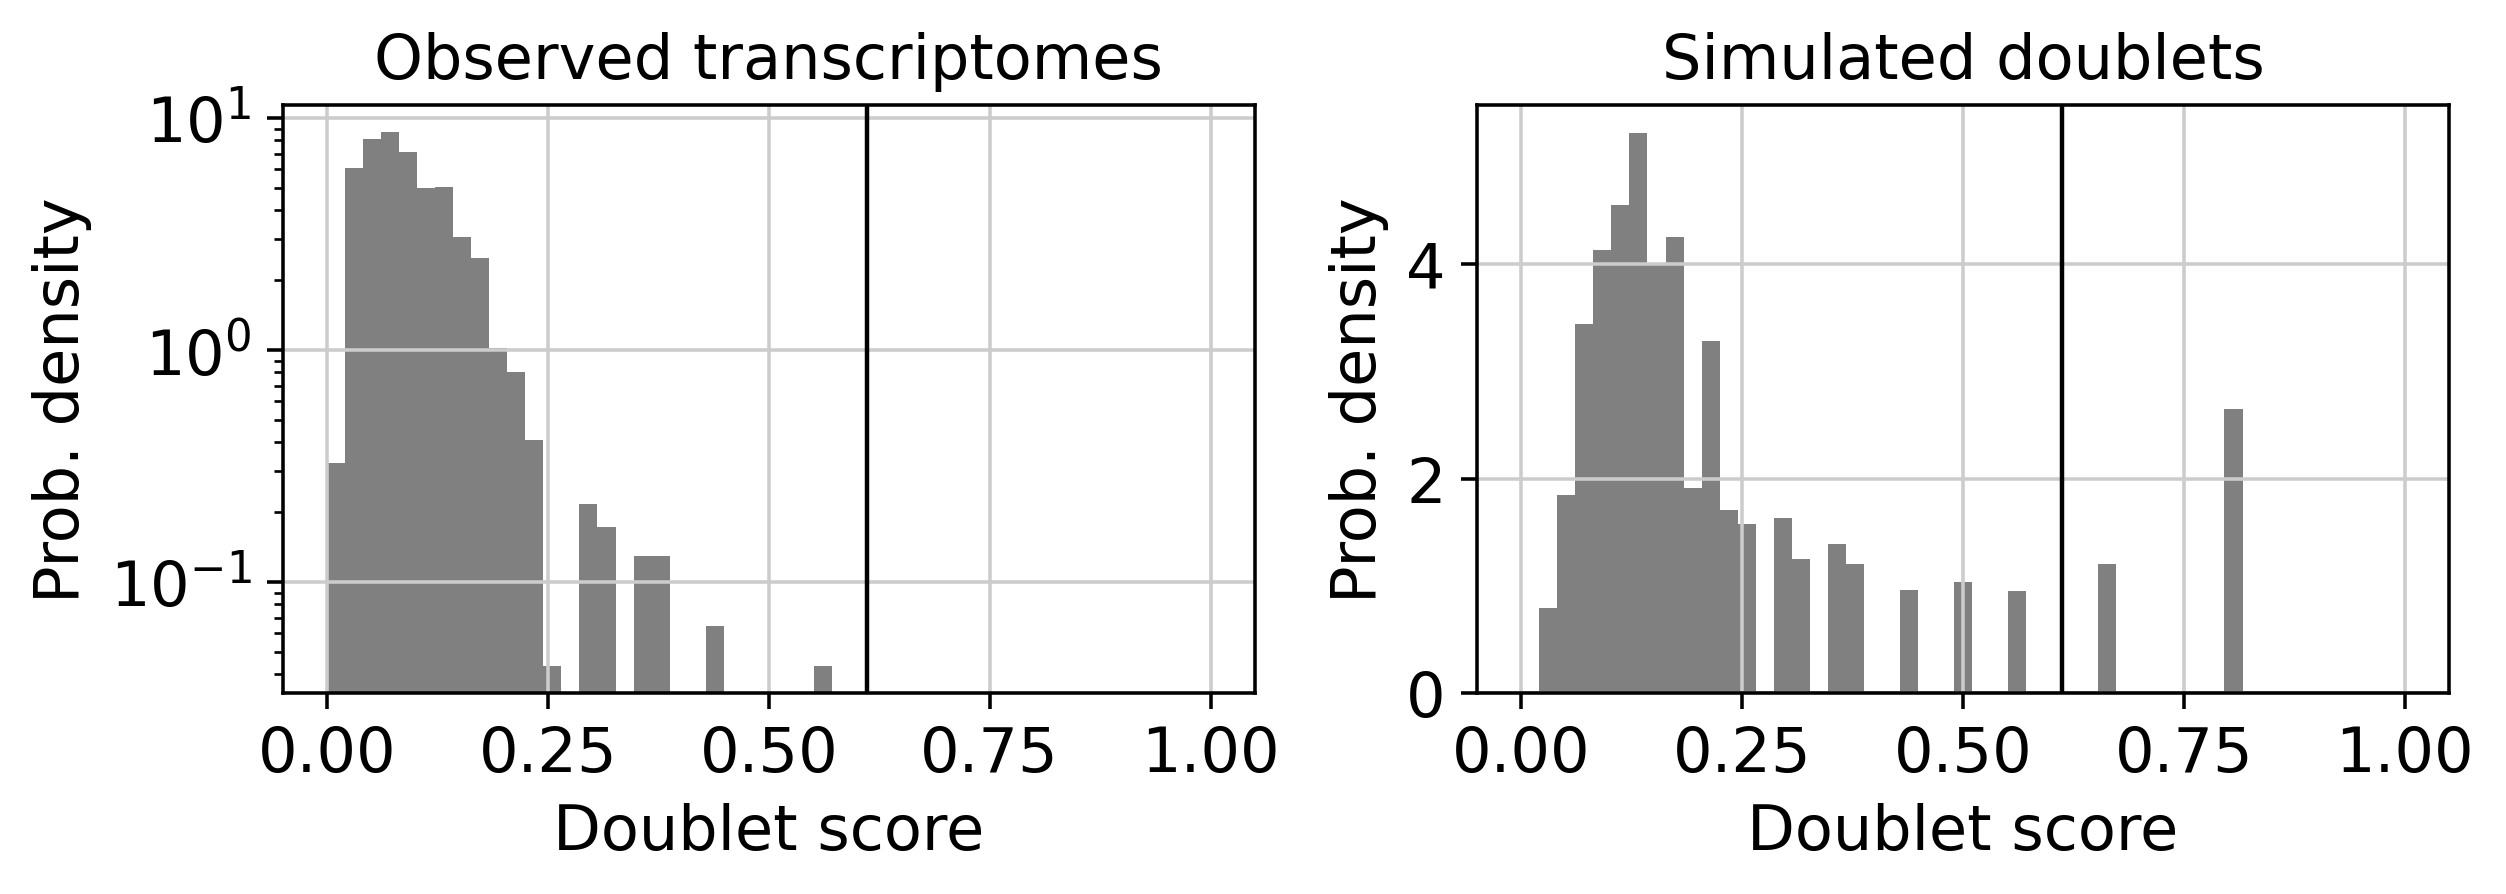

In [17]:
a4 = adata[adata.obs['Sample_ID'] == 'A4',:]
scrub = scrublet.Scrublet(a4.X)
a4.obs['doublet_scores'], a4.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(a4.obs['predicted_doublets'])

+ Sample A6

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.58
Detected doublet rate = 0.2%
Estimated detectable doublet fraction = 1.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 14.6%
Elapsed time: 1.4 seconds


/tmp/ipykernel_1477083/1639032081.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  a6.obs['doublet_scores'], a6.obs['predicted_doublets'] = scrub.scrub_doublets()


3

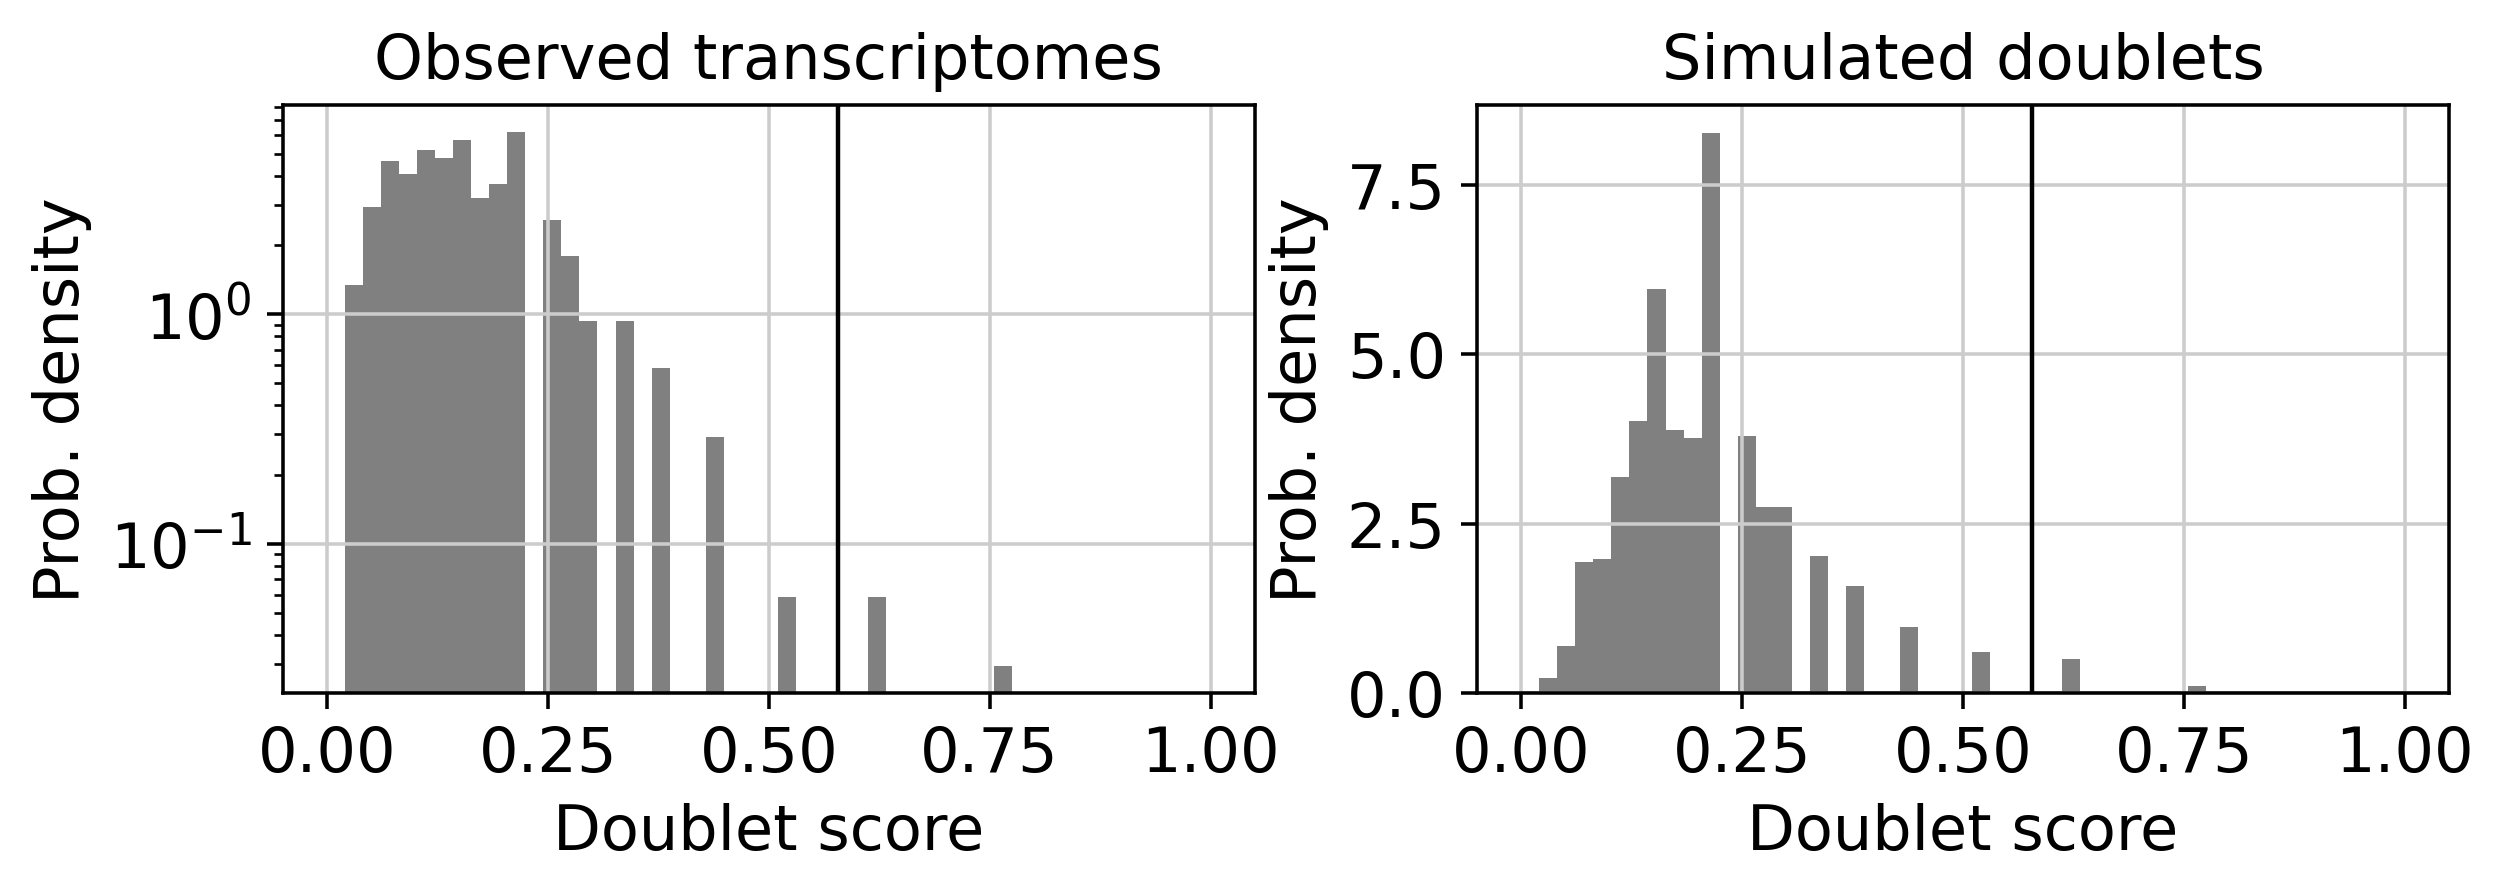

In [18]:
a6 = adata[adata.obs['Sample_ID'] == 'A6',:]
scrub = scrublet.Scrublet(a6.X)
a6.obs['doublet_scores'], a6.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(a6.obs['predicted_doublets'])

+ Sample A7

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.60
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 1.1%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 5.6%
Elapsed time: 1.4 seconds


/tmp/ipykernel_1477083/2933050351.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  a7.obs['doublet_scores'], a7.obs['predicted_doublets'] = scrub.scrub_doublets()


1

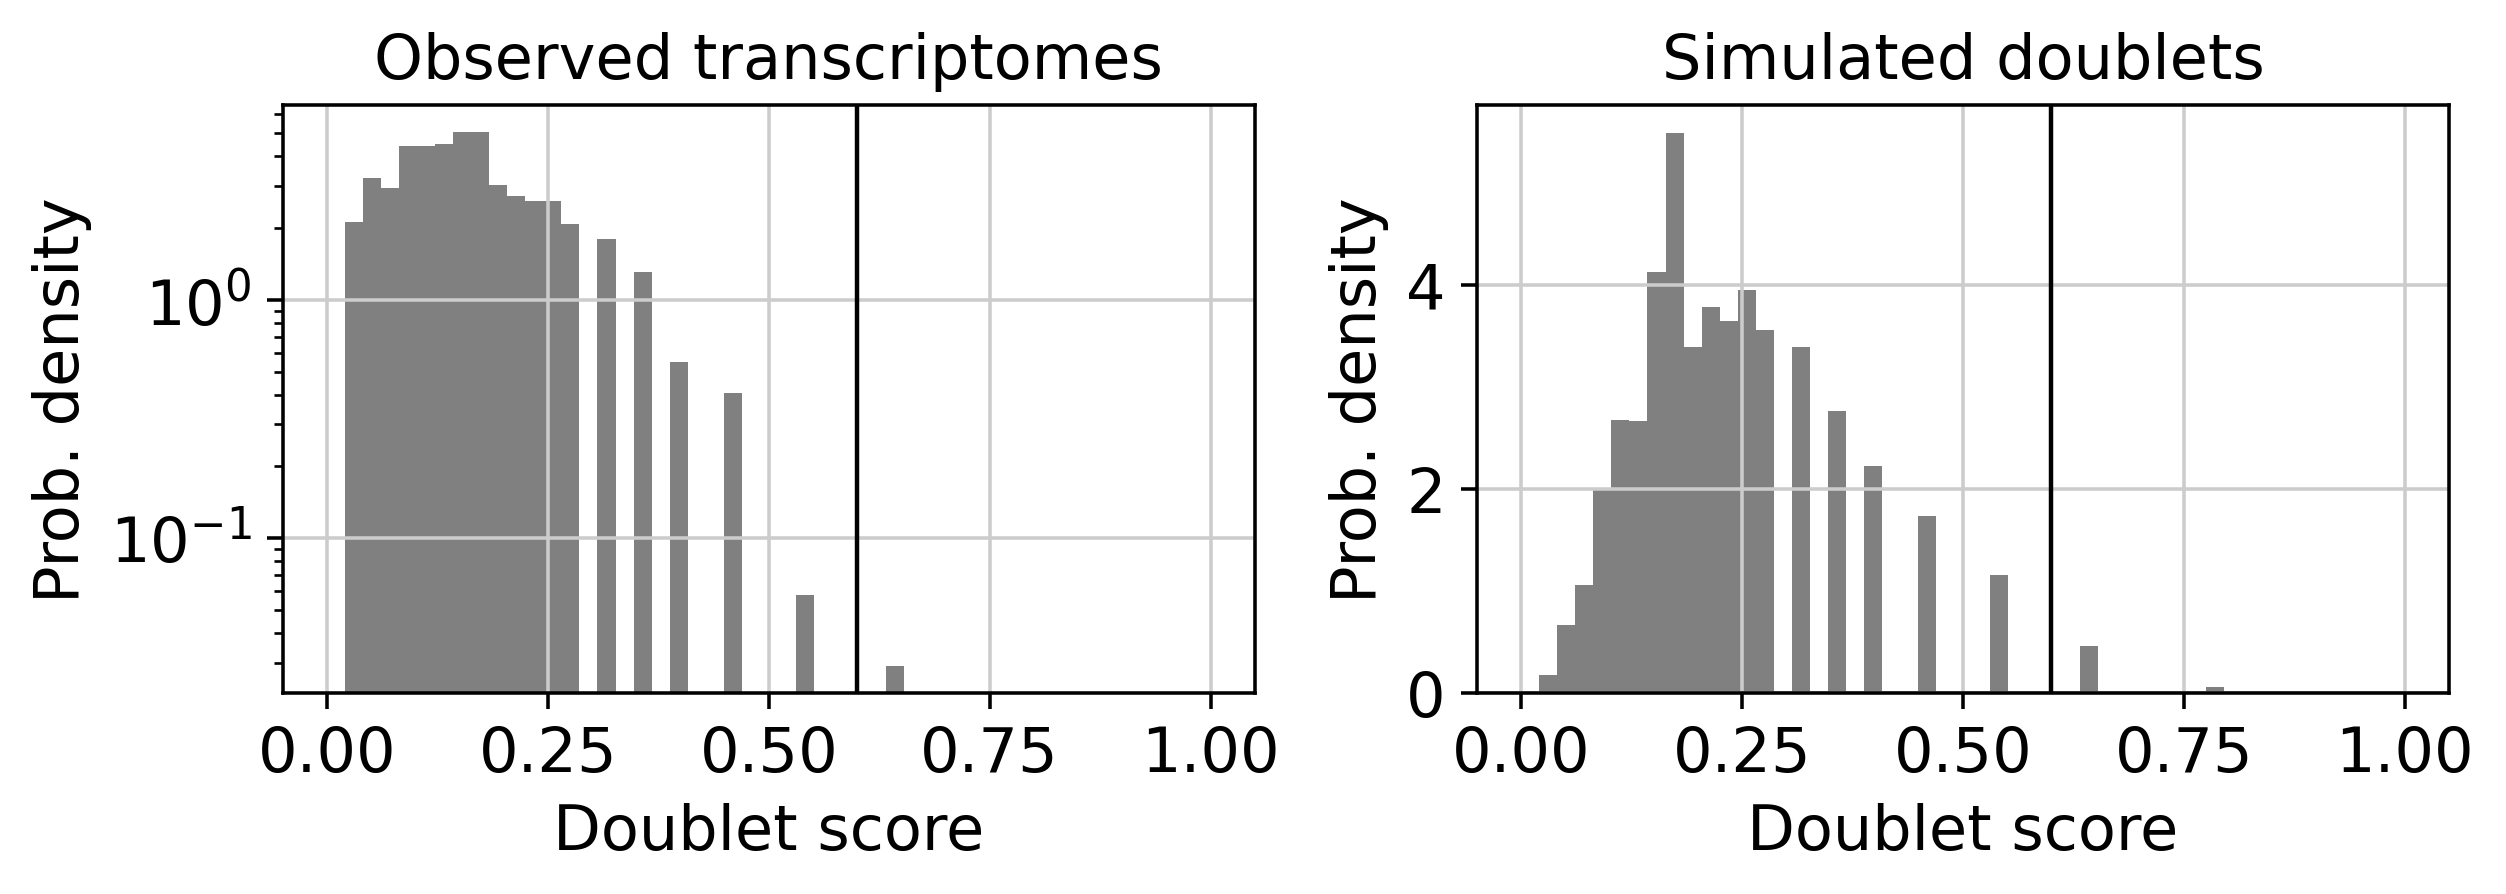

In [19]:
a7 = adata[adata.obs['Sample_ID'] == 'A7',:]
scrub = scrublet.Scrublet(a7.X)
a7.obs['doublet_scores'], a7.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(a7.obs['predicted_doublets'])

+ Sample A8

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.64
Detected doublet rate = 0.1%
Estimated detectable doublet fraction = 4.7%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 1.6%
Elapsed time: 2.3 seconds


/tmp/ipykernel_1477083/3615746099.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  a8.obs['doublet_scores'], a8.obs['predicted_doublets'] = scrub.scrub_doublets()


2

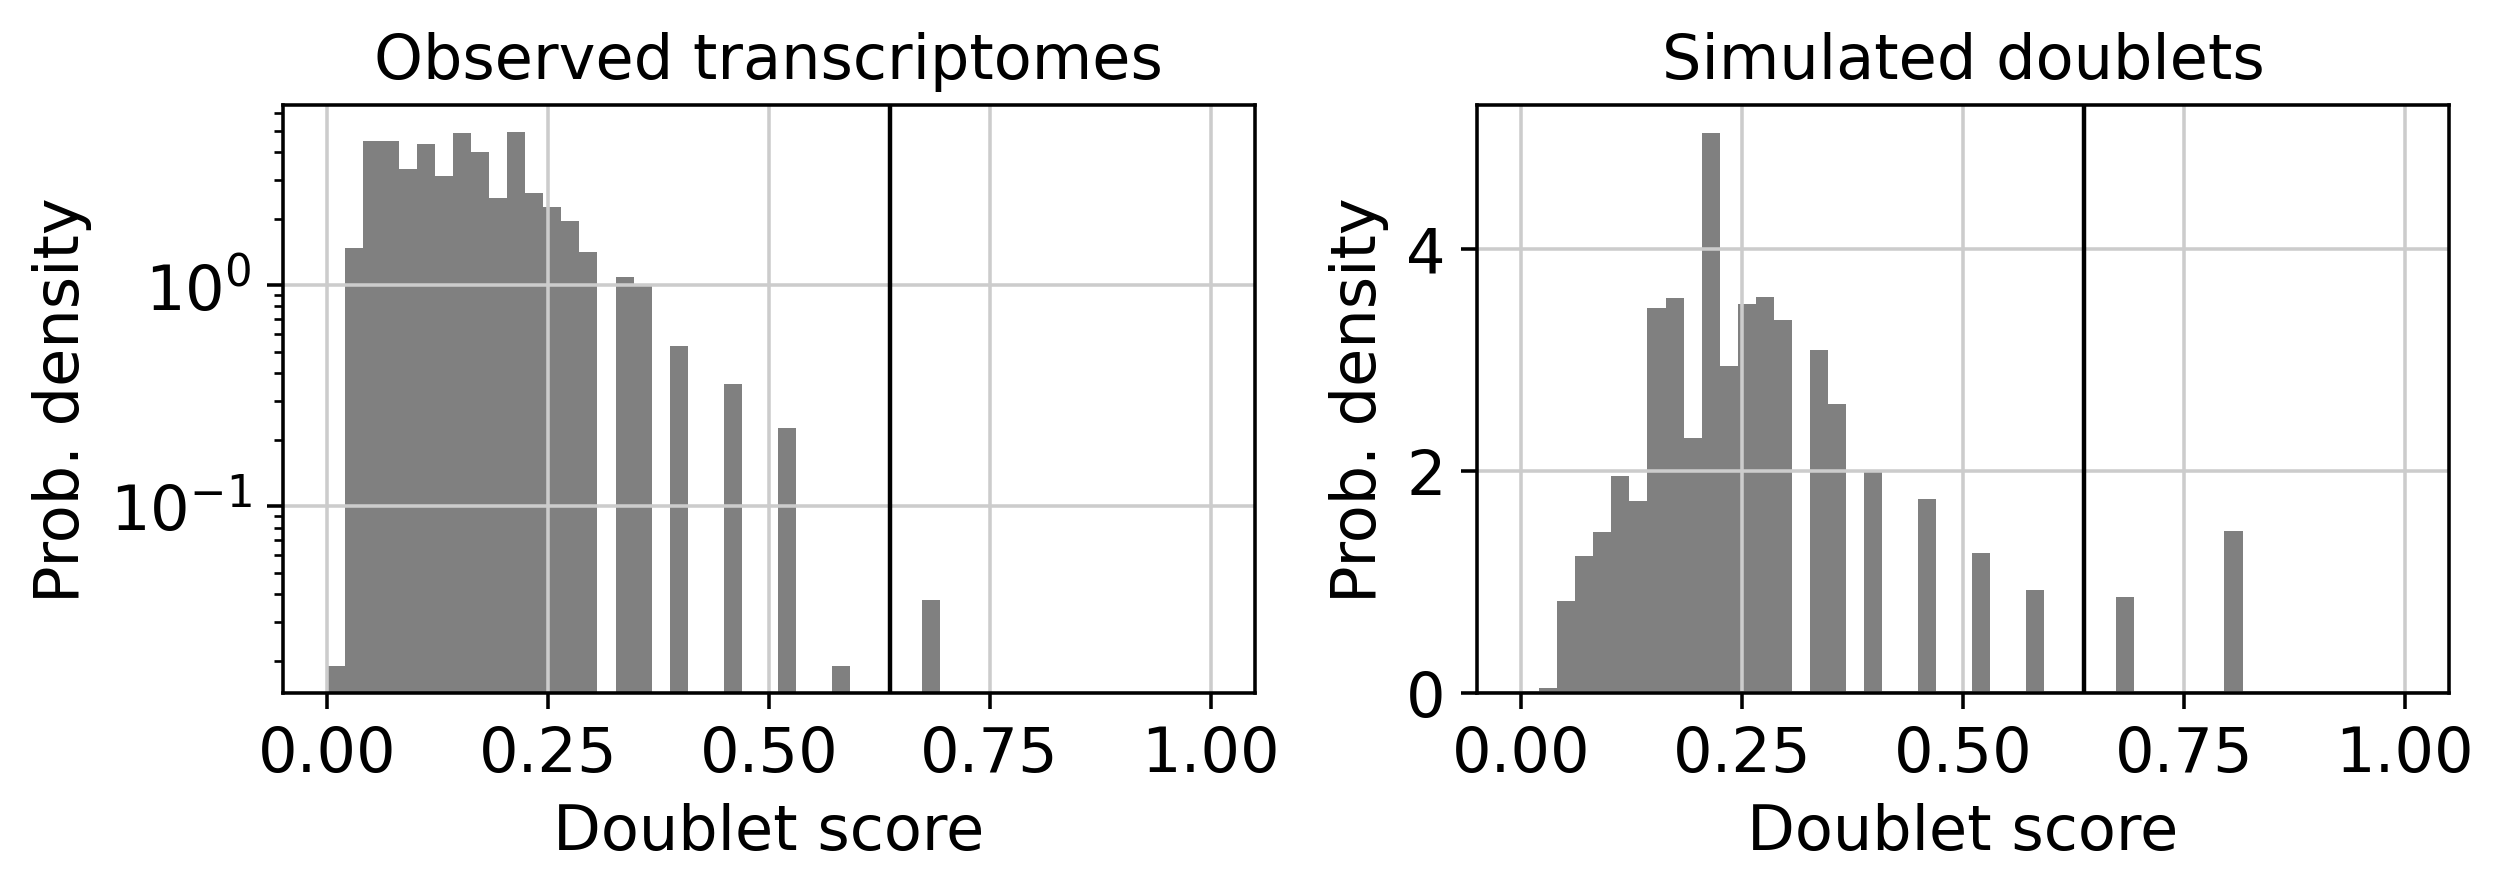

In [20]:
a8 = adata[adata.obs['Sample_ID'] == 'A8',:]
scrub = scrublet.Scrublet(a8.X)
a8.obs['doublet_scores'], a8.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(a8.obs['predicted_doublets'])

+ Sample A9

Preprocessing...
Simulating doublets...
Embedding transcriptomes using PCA...
Calculating doublet scores...
Automatically set threshold at doublet score = 0.63
Detected doublet rate = 0.3%
Estimated detectable doublet fraction = 2.2%
Overall doublet rate:
	Expected   = 10.0%
	Estimated  = 14.1%
Elapsed time: 1.8 seconds


/tmp/ipykernel_1477083/1888593809.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  a9.obs['doublet_scores'], a9.obs['predicted_doublets'] = scrub.scrub_doublets()


7

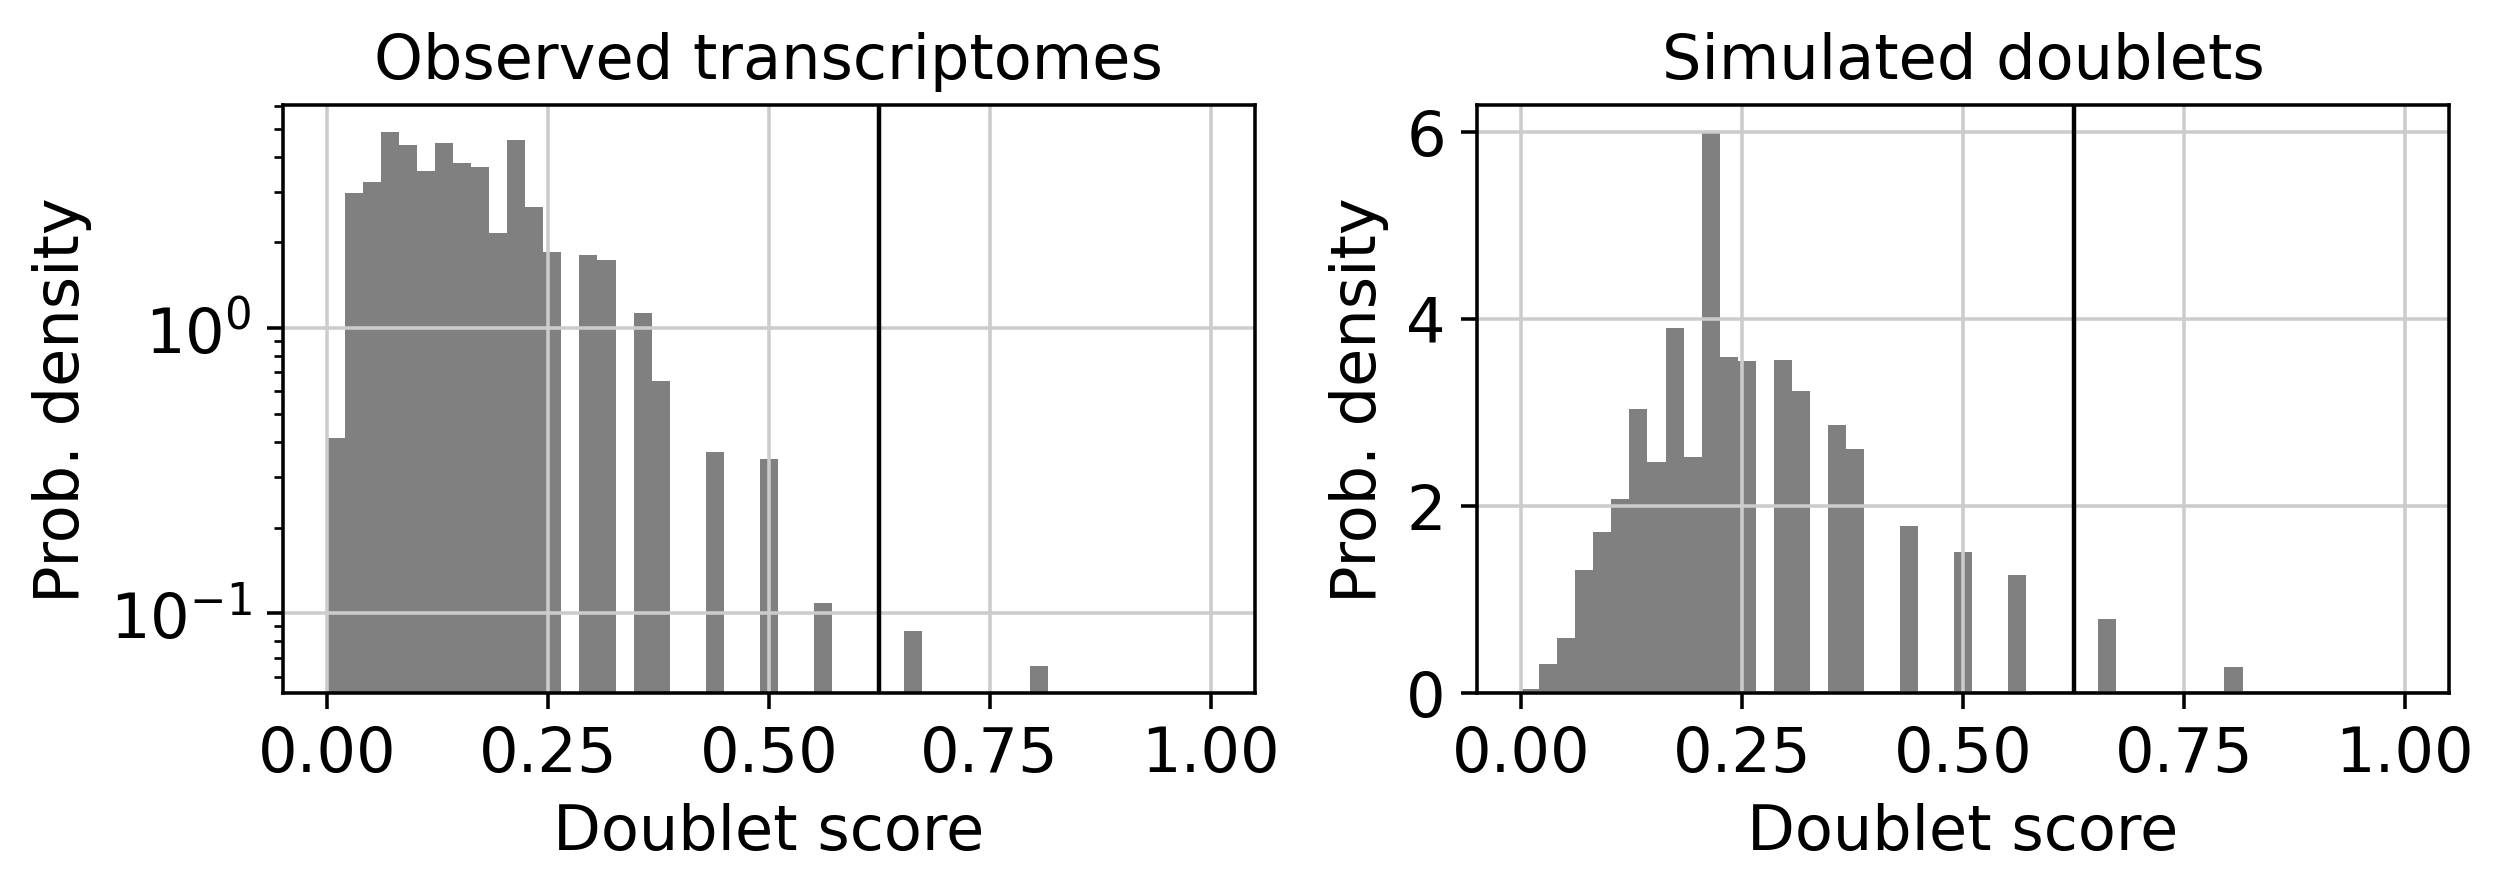

In [21]:
a9 = adata[adata.obs['Sample_ID'] == 'A9',:]
scrub = scrublet.Scrublet(a9.X)
a9.obs['doublet_scores'], a9.obs['predicted_doublets'] = scrub.scrub_doublets()
scrub.plot_histogram()

sum(a9.obs['predicted_doublets'])

+ Merge all objects

In [23]:
adata_merged = a1.concatenate(a2, a3, a4, a6, a7, a8, join = 'inner')

/tmp/ipykernel_1477083/4100880056.py:1: FutureWarning: Use anndata.concat instead of AnnData.concatenate, AnnData.concatenate is deprecated and will be removed in the future. See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  adata_merged = a1.concatenate(a2, a3, a4, a6, a7, a8, join = 'inner')


#### Perform basic QC

In [25]:
sc.pp.calculate_qc_metrics(adata_merged, inplace=True, percent_top= None, log1p = False)

In [26]:
adata_merged.var['mt'] = adata_merged.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
adata_merged.var['ribo'] = adata_merged.var_names.str.startswith('RPS','RPL')  # annotate the group of rybosomal genes as 'ribo'
sc.pp.calculate_qc_metrics(adata_merged, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

+ Visualise QC covariates

/home/amaguza/miniforge3/envs/squidpy_env/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/amaguza/miniforge3/envs/squidpy_env/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(
/home/amaguza/miniforge3/envs/squidpy_env/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/home/amaguza/miniforge3/envs/squidpy_env/lib/python3.9/site-packages/scanpy/plotting/_anndata.py:839: FutureWarning: 


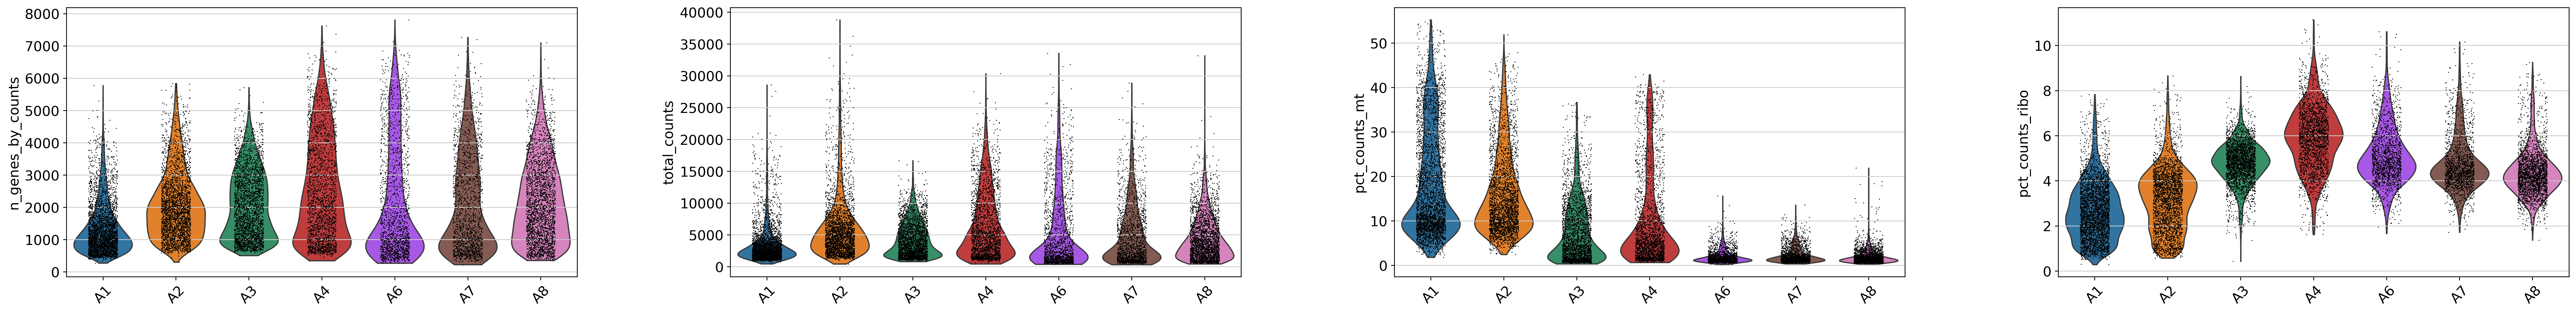

In [27]:
sc.set_figure_params(dpi=180, figsize=(8, 5))
sc.pl.violin(adata_merged, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_ribo'],
             jitter = 0.2, groupby = 'Sample_ID', rotation = 45)

In [29]:
# Save the file
adata_merged.write('/mnt/LaCIE/annaM/gut_project/raw_data/Fawkner-Corbett_2021/Fawkner_Corbett_2021_raw_all_samples_with_QC.h5ad')
